# Accuracy model

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn import preprocessing
import random

Keras

In [90]:
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras.backend as kb

## Model saver

In [3]:
class ModelSaver:
    def __init__(self, name = 'model', model = None):
        self.model = model
        self.fileName = name + '.pickle'
    def save(self, model = None):
        if (model == None):
            model = self.model
        pickle.dump(model, open(self.fileName, 'wb'))
    def load(self):
        model = pickle.load(open(self.fileName, 'rb'))
        return model

## Loading raw data

In [4]:
basicModel = ModelSaver('models/model1').load()

In [5]:
path = '../training-data-preprocessed/'
data = ModelSaver(path + 'data3').load()

In [6]:
xTrainModel = data['x_train'].transpose(0, 2, 3, 1)
yTrainModel = data['y_train']
xTestModel = data['x_test'].transpose(0, 2, 3, 1)
yTestModel = data['y_test']

## Preparing data

In [164]:
xTrain = basicModel.predict(xTrainModel)
xTest = basicModel.predict(xTestModel[:1500])

In [165]:
yTrain = np.array([int(np.argmax(xTrain[i]) == yTrainModel[i]) for i in range(0, len(xTrain))])
yTest = np.array([int(np.argmax(xTest[i]) == yTestModel[i]) for i in range(0, len(xTest))])

In [166]:
def equalize(x, y):
    trueResults = y[y == 1]
    falseResults = x[np.arange(len(y))[y == 0]]

    n = int(len(trueResults) / len(falseResults))
    xTemp = []
    for i in range (1, n):
        xTemp.append(falseResults)

    shape = np.array(xTemp).shape
    xTemp = np.array(xTemp).reshape((shape[0] * shape[1], shape[2]))
    x = np.concatenate((x, xTemp))
    y = np.concatenate((y, np.full(len(xTemp), 0)))
    return x, y

In [167]:
xTrain, yTrain = equalize(xTrain, yTrain)

In [168]:
print('True false ratio: ', len(yTrain[yTrain == 1]) / len(yTrain))

True false ratio:  0.5011359009612377


In [170]:
np.random.seed(0)
np.random.shuffle(xTrain)
np.random.seed(0)
np.random.shuffle(yTrain)

In [171]:
xTrain = preprocessing.scale(xTrain, axis=1)
xTest = preprocessing.scale(xTest, axis=1)

xTrain = preprocessing.minmax_scale(xTrain, axis=0) * 2 - 1
xTest = preprocessing.minmax_scale(xTest, axis=0) * 2 - 1

/home/adam/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/home/adam/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [175]:
xTrain = np.array(np.sort(xTrain, axis=1))[:, :20]
xTest = np.array(np.sort(xTest, axis=1))[:, :20]

In [176]:
xTrain.shape

(169469, 20)

## Setting up a model

In [177]:
model = Sequential()
model.add(Dense(300, input_dim = 20, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

In [113]:
@tf.function
def loss(predicted, actual):
    sq = tf.square(predicted - actual)
    return tf.cond(tf.less(tf.constant(0.25), sq), lambda: tf.constant(1), lambda: sq)

@tf.function
def loss_function(predicted, actual):
    return kb.mean(kb.sum(loss(predicted, actual)))

In [178]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [179]:
results = model.fit(xTrain, yTrain, 
                    epochs=10,  batch_size=10,
                    validation_data=(xTest, yTest),
                    verbose=2)

Train on 169469 samples, validate on 1500 samples
Epoch 1/10
 - 36s - loss: 0.2424 - accuracy: 0.5837 - val_loss: 0.4026 - val_accuracy: 0.1260
Epoch 2/10
 - 41s - loss: 0.1503 - accuracy: 0.8464 - val_loss: 0.8514 - val_accuracy: 0.1260
Epoch 3/10
 - 39s - loss: 0.0908 - accuracy: 0.8986 - val_loss: 0.8732 - val_accuracy: 0.1260
Epoch 4/10


KeyboardInterrupt: 

## Test and evaluation

In [77]:
score = model.evaluate(xTest, yTest, verbose=1)
print('Test accuracy: ', score[1])

1500/1500 [==============================] - 0s 120us/step
Test accuracy:  0.8893333077430725


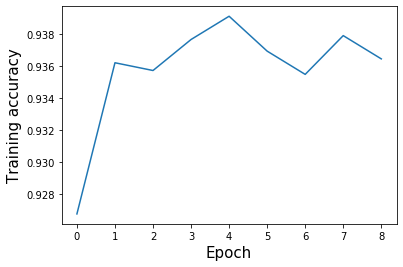

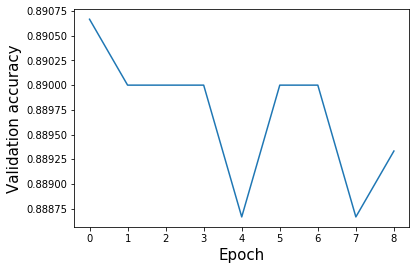

In [78]:
plt.plot(results.history['accuracy'])
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Training accuracy', fontsize=15)
plt.show()
plt.plot(results.history['val_accuracy'])
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Validation accuracy', fontsize=15)
plt.show()

In [79]:
def showPrediction(n):
    prediction = model.predict(np.array([xTest[n]]))
    print('Prediction:', (prediction[0][0] * 100), '%')
    print('Actual:', yTest[n])

In [80]:
for i in range(0, 1000):
    prediction = model.predict(np.array([xTest[i]]))
    if (not (-0.7 < prediction[0][0] - yTest[i] < 0.7)):
        showPrediction(i)

Prediction: 100.0 %
Actual: 0
Prediction: 92.1393632888794 %
Actual: 0
Prediction: 100.0 %
Actual: 0
Prediction: 7.718332856893539 %
Actual: 1
Prediction: 100.0 %
Actual: 0
Prediction: 100.0 %
Actual: 0
Prediction: 99.99996423721313 %
Actual: 0
Prediction: 100.0 %
Actual: 0
Prediction: 26.442310214042664 %
Actual: 1
Prediction: 29.596370458602905 %
Actual: 1
Prediction: 100.0 %
Actual: 0
Prediction: 100.0 %
Actual: 0
Prediction: 100.0 %
Actual: 0
Prediction: 79.26551699638367 %
Actual: 0
Prediction: 99.9994158744812 %
Actual: 0
Prediction: 99.95143413543701 %
Actual: 0
Prediction: 100.0 %
Actual: 0
Prediction: 99.86853003501892 %
Actual: 0
Prediction: 99.99971389770508 %
Actual: 0
Prediction: 15.29499888420105 %
Actual: 1
Prediction: 100.0 %
Actual: 0
Prediction: 100.0 %
Actual: 0
Prediction: 100.0 %
Actual: 0
Prediction: 100.0 %
Actual: 0
Prediction: 100.0 %
Actual: 0
Prediction: 100.0 %
Actual: 0
Prediction: 100.0 %
Actual: 0
Prediction: 99.33953881263733 %
Actual: 0
Prediction: 99.9